<a href="https://colab.research.google.com/github/wadaxy/artificial-intelligence-with-python-ja/blob/master/notebooks/ch06_bi_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6章　2値分類

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [4]:
# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

## 6.5 シグモイド関数

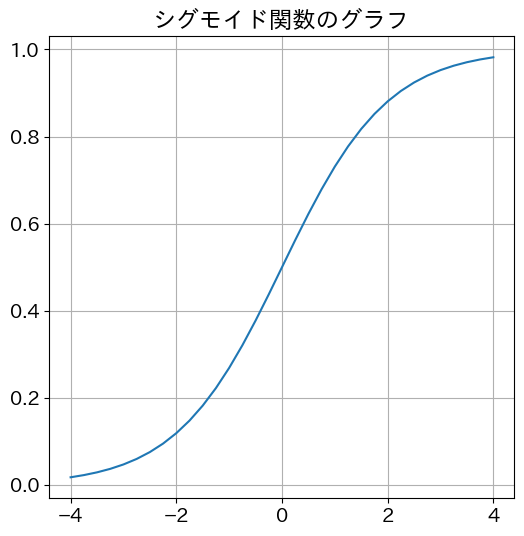

In [5]:
# NumPy配列でxデータを定義
x_np = np.arange(-4, 4.1, 0.25)

# データをTensor形式に変換
x = torch.tensor(x_np).float()

# yの値を計算
y = torch.sigmoid(x)

# グラフ描画
plt.title('シグモイド関数のグラフ')
plt.plot(x.data, y.data)
plt.show()

## 6.7 データ準備

In [6]:
# 学習用データ準備

# ライブラリのインポート
from sklearn.datasets import load_iris

# データ読み込み
iris = load_iris()

# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target

# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [7]:
# データ絞り込み
#   クラス0, 1のみ
#   項目sepal_lengthとsepal_widthのみ

x_data = iris.data[:100,:2]
y_data = iris.target[:100]

# 結果確認
print('対象データ', x_data.shape, y_data.shape)

対象データ (100, 2) (100,)


### 訓練データ・検証データの分割

In [8]:
# 　元データのサイズ
print(x_data.shape, y_data.shape)

# 訓練データ、検証データに分割 (シャフルも同時に実施)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30,
    random_state=123)       # データに偏りがないようにシャッフル
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


### 訓練データの散布図表示

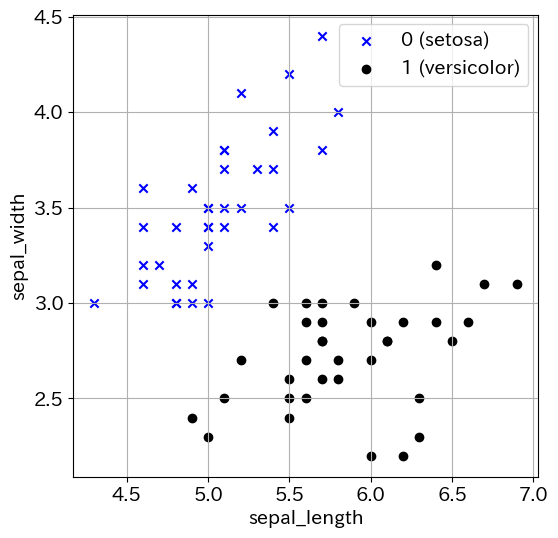

In [9]:
# 散布図の表示

x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## 6.8 モデル定義

In [10]:
# 入力次元数　(今の場合2)
n_input= x_train.shape[1]

# 出力次元数
n_output = 1

# 結果確認
print(f'n_input: {n_input}  n_output:{n_output}')

n_input: 2  n_output:1


In [12]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル
#  P174 コード5-20参照

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()

        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    # 予測関数の定義
    def forward(self, x):
        # 最初に入力値を線形関数にかけたを計算する
        x1 = self.l1(x)
        # 計算結果にシグモイド関数をかける
        x2 = self.sigmoid(x1)
        return x2

In [13]:
# インスタンスの生成

net = Net(n_input, n_output)

### モデル確認

In [14]:
# モデル内のパラメータの確認
# l1.weightとl1.biasがあることがわかる

for parameter in net.named_parameters():
    print(parameter)

('l1.weight', Parameter containing:
tensor([[1., 1.]], requires_grad=True))
('l1.bias', Parameter containing:
tensor([1.], requires_grad=True))


In [15]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
# モデルのサマリー表示

summary(net, (2,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       3
├─Sigmoid: 1-2                           [1]                       --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### 最適化アルゴリズムと損失関数

In [18]:
# 損失関数： 交差エントロピー関数
# P179 コード5-26参照
criterion = nn.BCELoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

## 6.9 勾配降下法

In [19]:
# 入力データ x_train と正解データ y_train のテンソル化
# コード5-27, 5-28参照

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

# 正解データはN行1列の行列に変換する
labels1 = labels.view((-1,1))

# 検証データのテンソル化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

# 検証用の正解データもN行1列の行列に変換する
labels1_test = labels_test.view((-1,1))

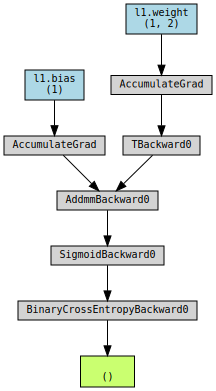

In [20]:
# 予測計算
# コード5-30 & 5-31 参照
outputs = net(inputs)

# 損失計算
loss = criterion(outputs, labels1)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 繰り返し計算

In [21]:
# コード5-35参照
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.BCELoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

history変数が前章2から今回5に増えた
第1要素: 繰り返し数
第2要素: 訓練データの損失
第3要素: 訓練データの精度
第4要素: 検証データの損失
第5要素: 検証データの精度

In [22]:
# コード5-36参照(P187)
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ

    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 損失の保存(スカラー値の取得)
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.5, 0, 1)

    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels1_test)

    # 損失の保存（スカラー値の取得）
    val_loss =  loss_test.item()

    # 予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)

    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77289 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84329 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

## 6.10 結果確認

In [23]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 4.49384 精度: 0.50000
最終状態: 損失: 0.15395 精度: 0.96667


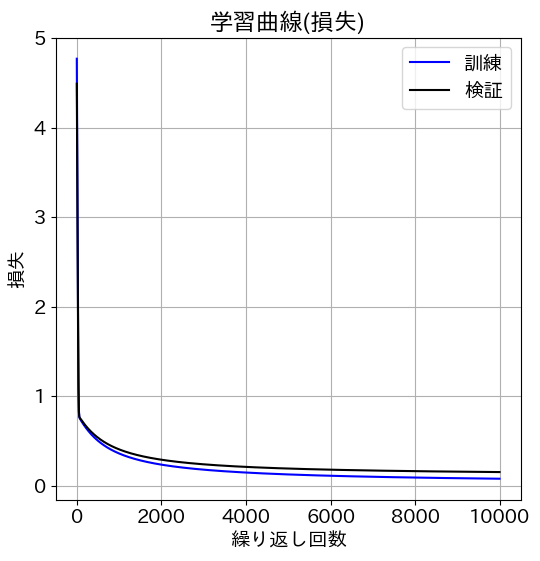

In [24]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

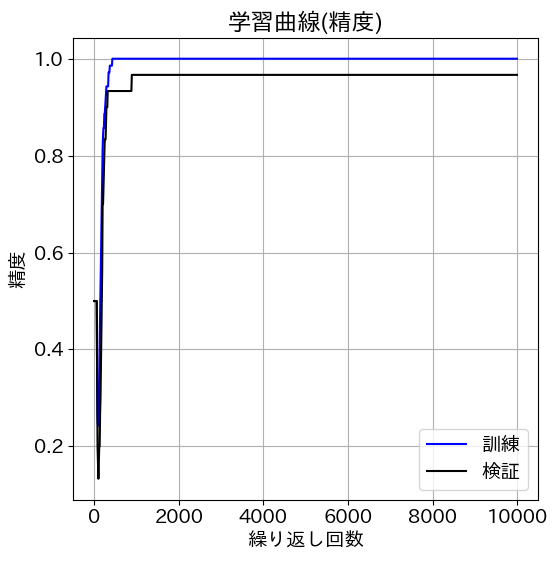

In [25]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

### 決定境界のグラフ表示

In [26]:
# 検証データを散布図用に準備

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

In [27]:
# パラメータの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386128], WEIGHT = [[ 2.9700322 -5.300015 ]]
xl = [4.4 7. ]  yl = [2.52956918 3.986562  ]


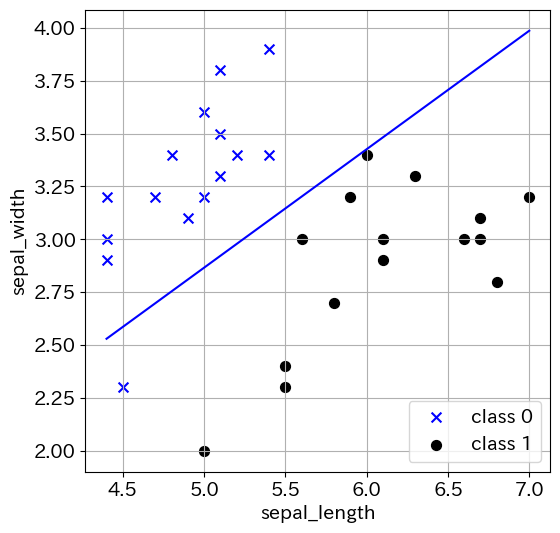

In [28]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x',
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o',
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

## コラム　BCELoss関数とBCEWithLogitsLoss関数の違い

In [29]:
# モデルの定義
# 2入力1出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)

        # 初期値を全部1にする
        # 「ディープラーニングの数学」と条件を合わせる目的
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    # 予測関数の定義
    def forward(self, x):
        # 入力値と行列の積を計算する
        x1 = self.l1(x)
        return x1

In [30]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： logits付き交差エントロピー関数
criterion = nn.BCEWithLogitsLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 記録用リストの初期化
history = np.zeros((0,5))

In [31]:
# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 訓練フェーズ

    #勾配値初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels1)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    # 損失のスカラー化
    train_loss = loss.item()

    # 予測ラベル(1 or 0)計算
    predicted = torch.where(outputs < 0.0, 0, 1)

    # 精度計算
    train_acc = (predicted == labels1).sum() / len(y_train)

    # 予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels1_test)

    # 損失のスカラー化
    val_loss =  loss_test.item()

    #予測ラベル(1 or 0)計算
    predicted_test = torch.where(outputs_test < 0.0, 0, 1)

    # 精度計算
    val_acc = (predicted_test == labels1_test).sum() / len(y_test)

    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 4.77294 acc: 0.50000 val_loss: 4.49384, val_acc: 0.50000
Epoch [10/10000], loss: 3.80546 acc: 0.50000 val_loss: 3.56537, val_acc: 0.50000
Epoch [20/10000], loss: 2.84328 acc: 0.50000 val_loss: 2.64328, val_acc: 0.50000
Epoch [30/10000], loss: 1.91613 acc: 0.50000 val_loss: 1.76244, val_acc: 0.50000
Epoch [40/10000], loss: 1.17137 acc: 0.50000 val_loss: 1.08537, val_acc: 0.50000
Epoch [50/10000], loss: 0.84140 acc: 0.50000 val_loss: 0.81872, val_acc: 0.50000
Epoch [60/10000], loss: 0.77087 acc: 0.50000 val_loss: 0.77093, val_acc: 0.50000
Epoch [70/10000], loss: 0.75450 acc: 0.34286 val_loss: 0.76105, val_acc: 0.33333
Epoch [80/10000], loss: 0.74542 acc: 0.25714 val_loss: 0.75447, val_acc: 0.20000
Epoch [90/10000], loss: 0.73734 acc: 0.24286 val_loss: 0.74778, val_acc: 0.16667
Epoch [100/10000], loss: 0.72949 acc: 0.24286 val_loss: 0.74098, val_acc: 0.13333
Epoch [110/10000], loss: 0.72180 acc: 0.27143 val_loss: 0.73419, val_acc: 0.16667
Epoch [120/10000], loss: 0.

In [32]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 4.49384 精度: 0.50000
最終状態: 損失: 0.15395 精度: 0.96667


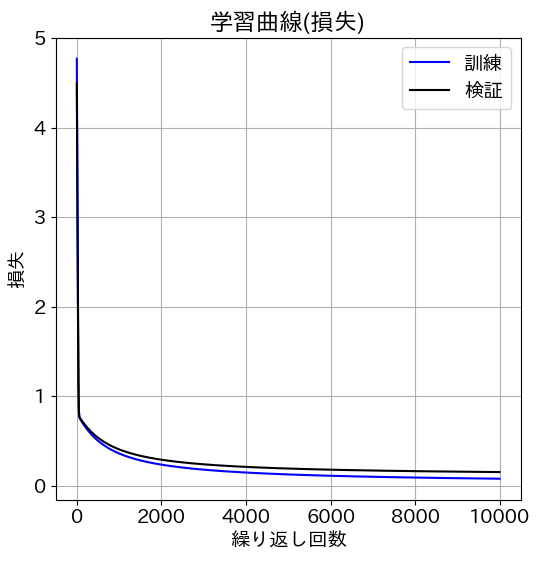

In [33]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

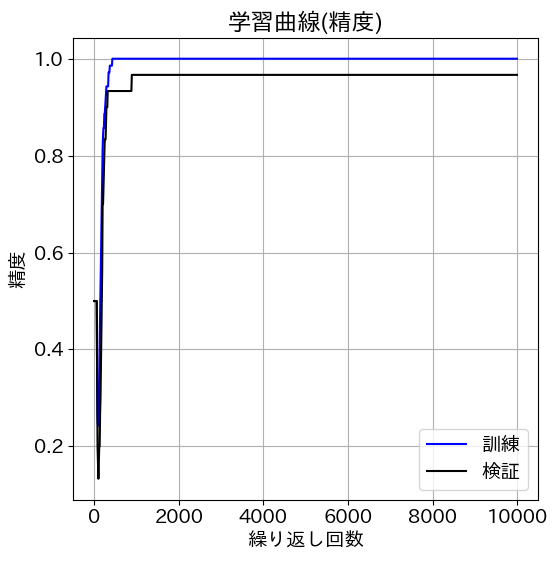

In [34]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [35]:
# パラメータの取得

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.33861232], WEIGHT = [[ 2.9700327 -5.3000154]]
xl = [4.4 7. ]  yl = [2.52956926 3.98656218]


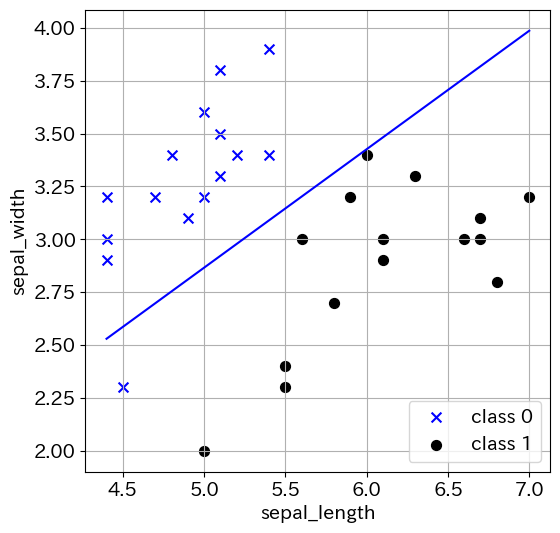

In [36]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x',
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o',
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()